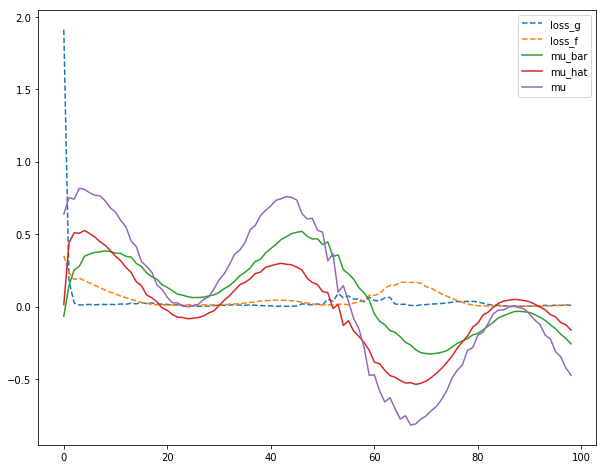

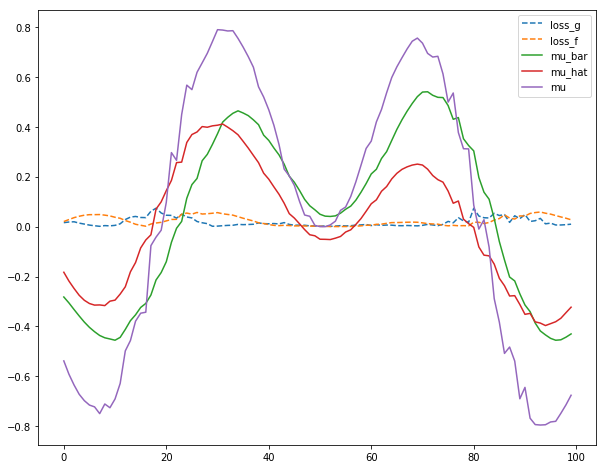

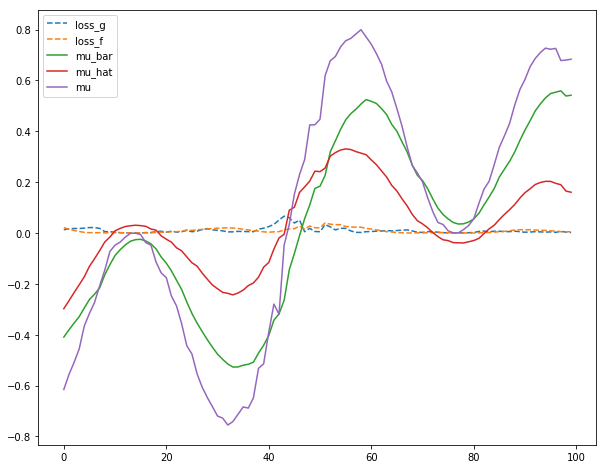

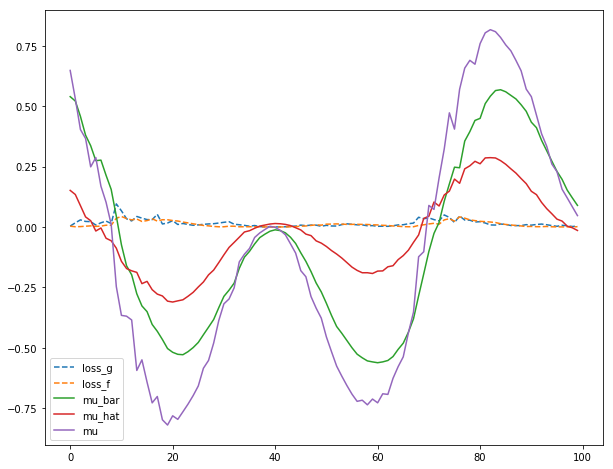

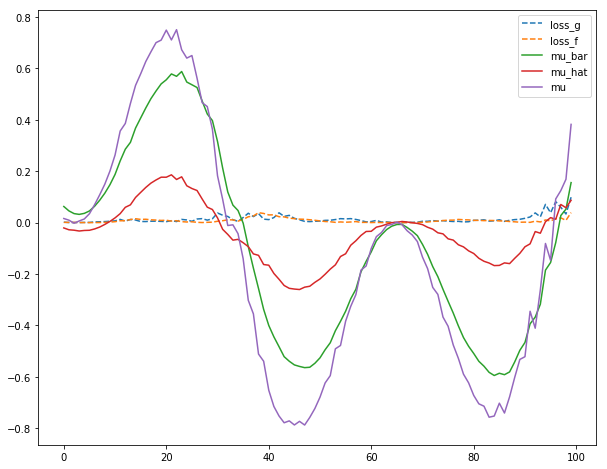

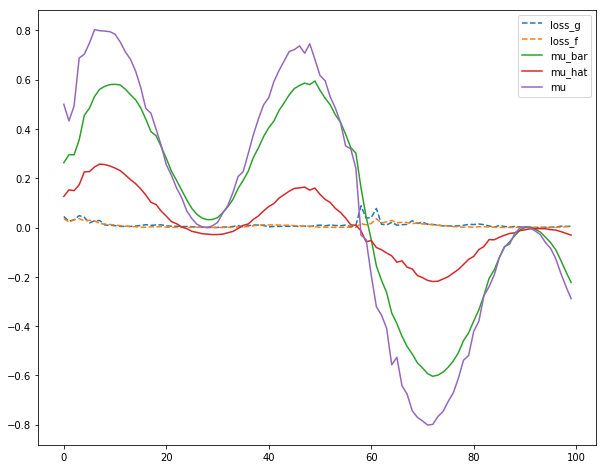

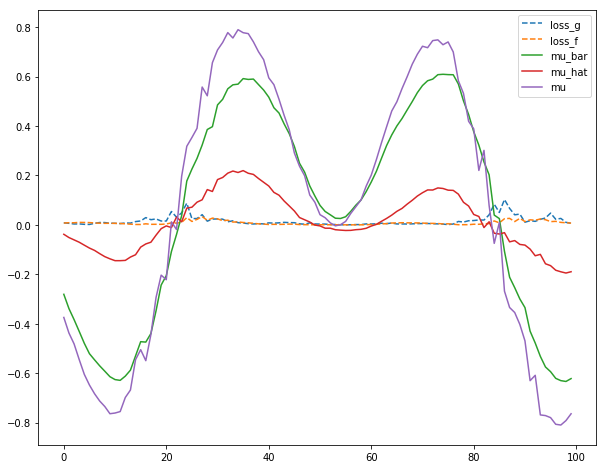

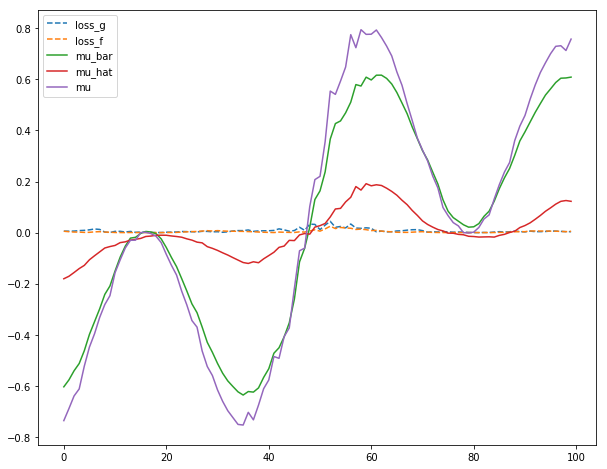

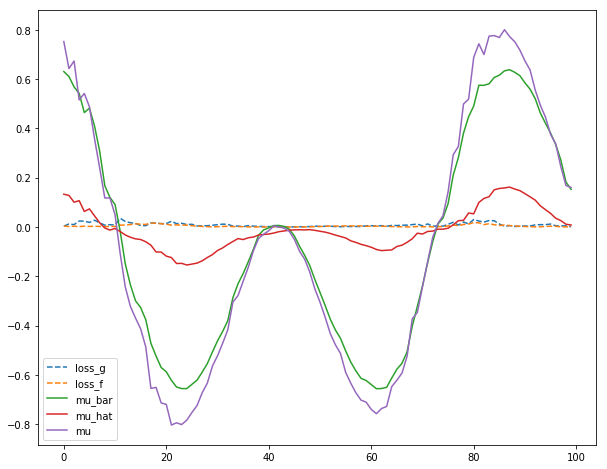

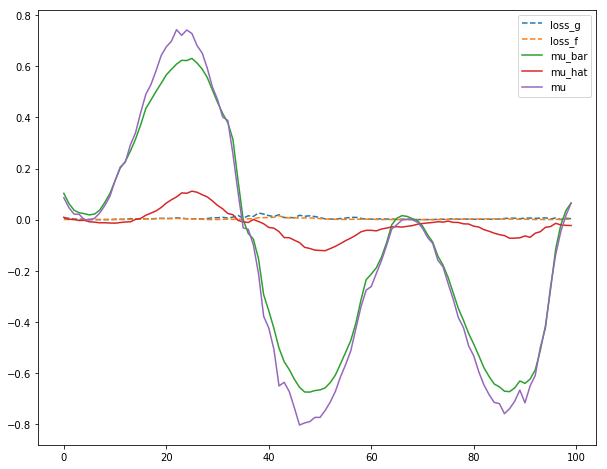

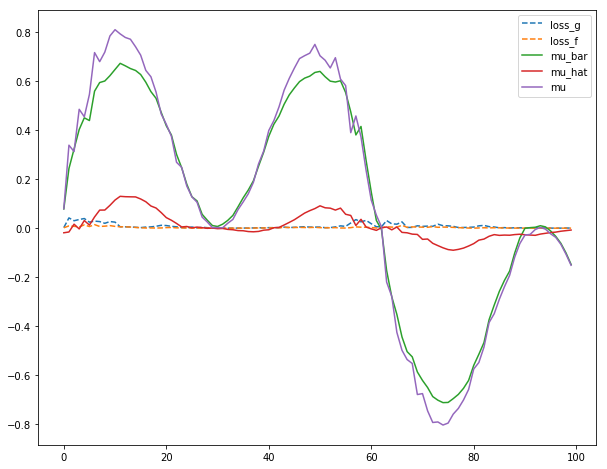

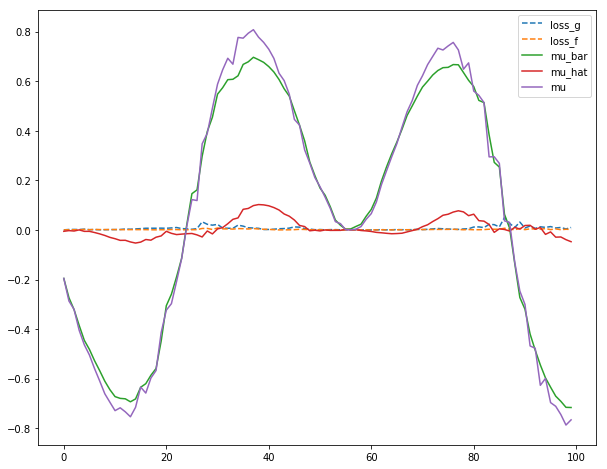

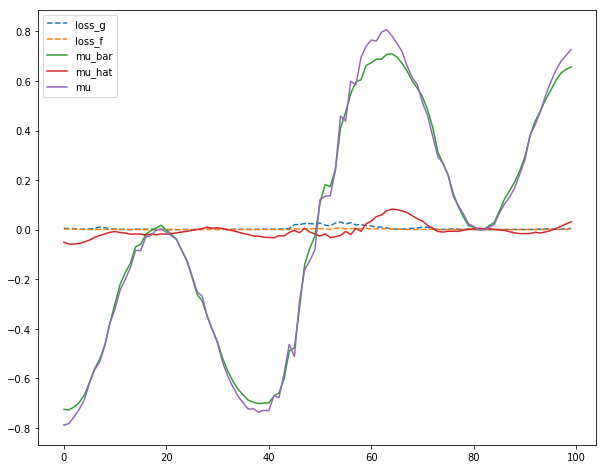

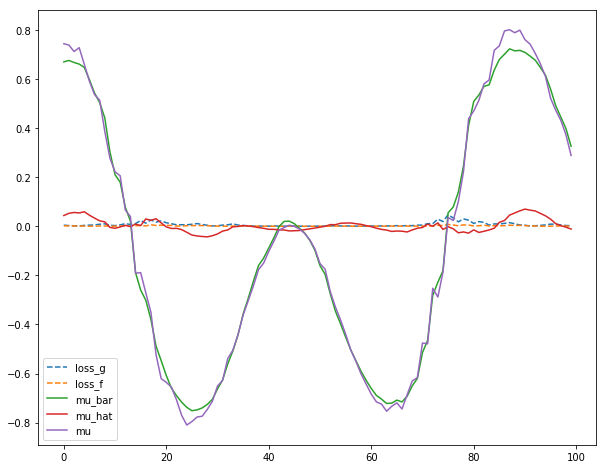

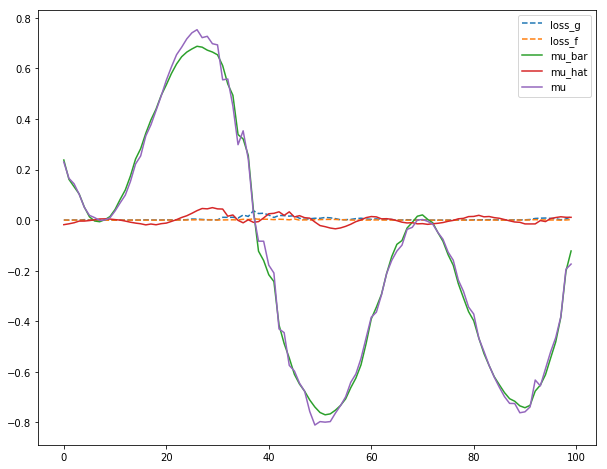

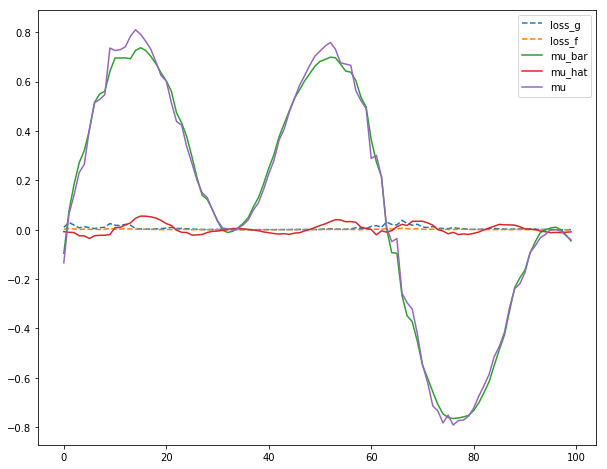

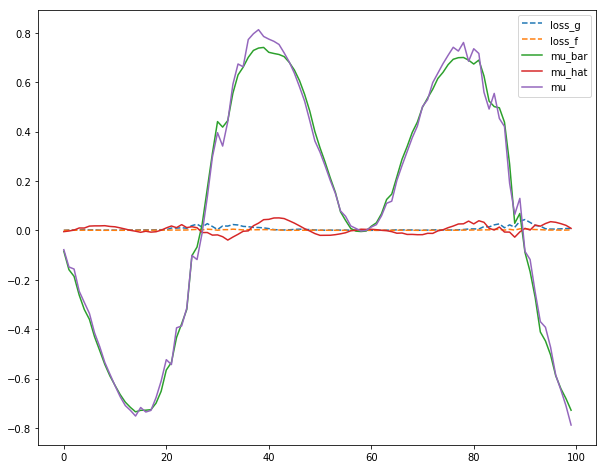

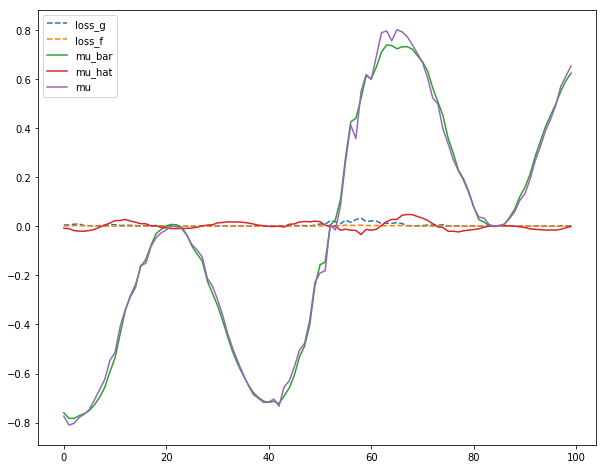

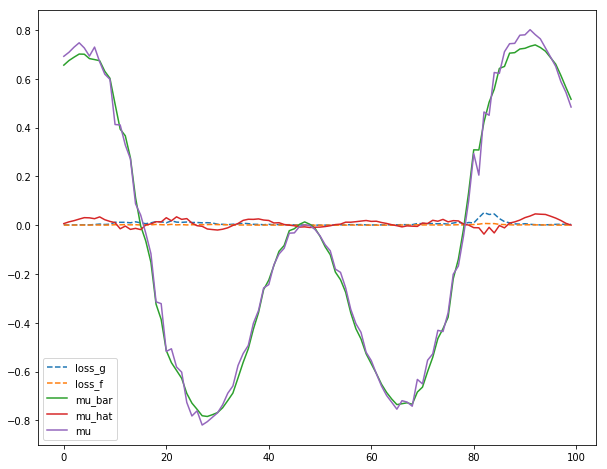

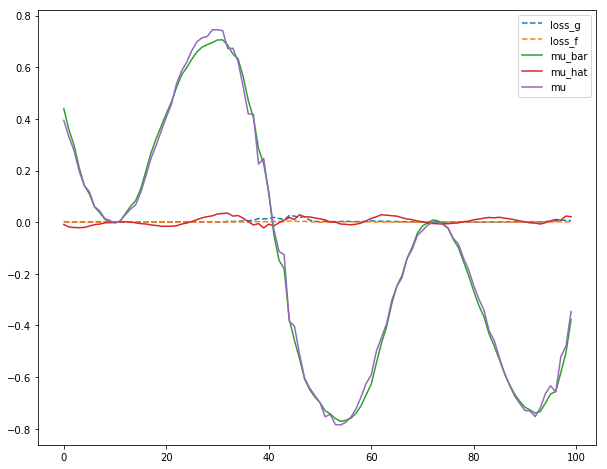

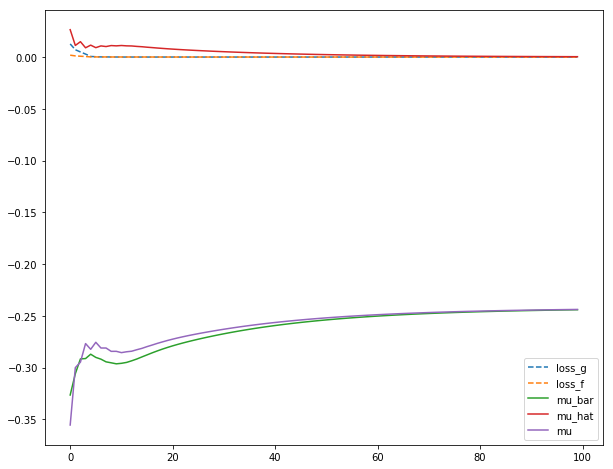

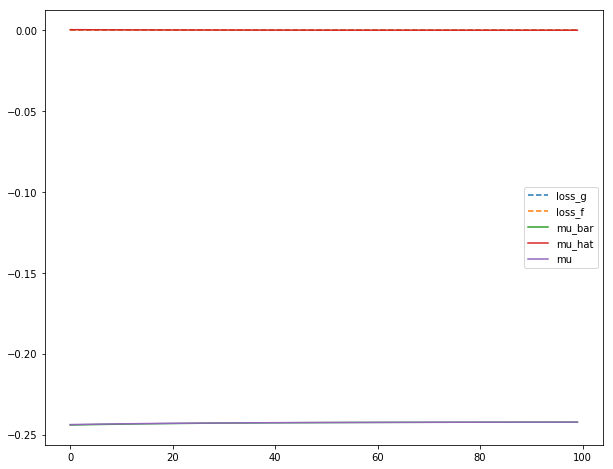

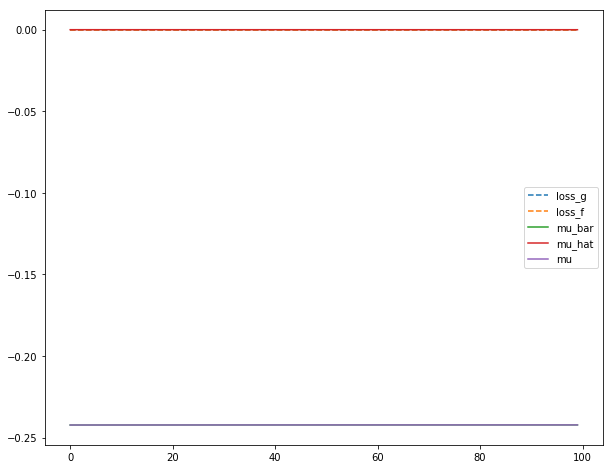

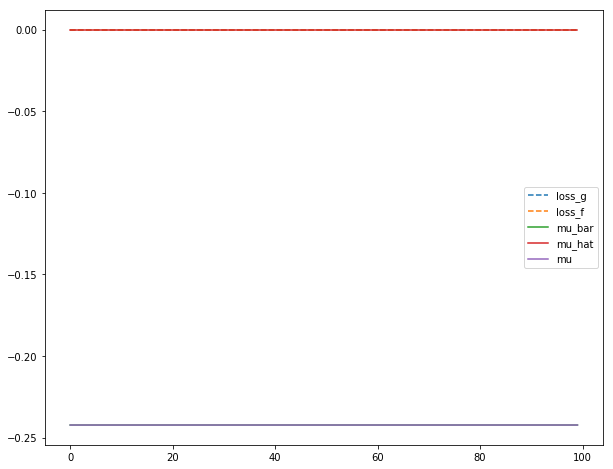

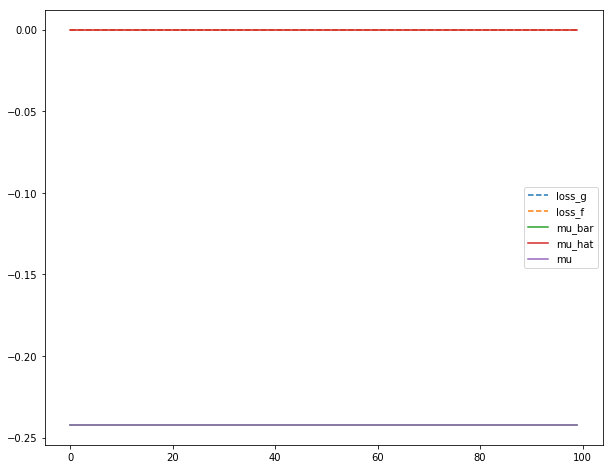

In [46]:
from __future__ import print_function
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from torchviz import make_dot
import pdb

class G(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=10, t_sample=1):
        super(G, self).__init__()
        self.g1 = nn.Linear(input_size * t_sample, hidden_size)
        self.g2 = nn.Linear(hidden_size, output_size * t_sample)
        self.act = nn.Tanh()

    def forward(self, x):
        x = F.relu(self.g1(x))
        x = self.g2(x)
        x = self.act(x)
        return x
    
class Unit(nn.Module):
    def __init__(self, mu_size, mu_next_size, t_sample):
        super(Unit, self).__init__()
        self.g = G(input_size=mu_next_size, output_size=mu_size, t_sample=t_sample)
        self.f = G(input_size=mu_size, output_size=mu_size, t_sample=t_sample)
        lr = 0.05
        self.optimizer_g = optim.SGD(self.g.parameters(), lr=lr, momentum=0)
        self.optimizer_f = optim.SGD(self.f.parameters(), lr=lr, momentum=0)
        self.previous_mu = None

    def forward(self, mu, mu_next):
        #print('self.mu0         = {}'.format(mu))

        self.mu_bar = self.f(mu)
        #print('self.mu_bar      = {}'.format(self.mu_bar))

        self.mu_hat = self.g(mu_next)
        #print('self.mu1         = {}'.format(mu_next))
        #print('self.mu_hat      = {}'.format(self.mu_hat))
        #print('-----------------')
        
    def t(self, arr, device):
        return torch.tensor(arr).to(device)

    def step(self, mu, mu_next, device):
        if self.previous_mu is not None:
            self.g.train()
            self.f.train()

            self.optimizer_g.zero_grad()
            self.optimizer_f.zero_grad()

            self.forward(mu, mu_next)

            #print('self.mu_hat = {}'.format(self.mu_hat))
            #print('mu - self.mu_bar = {}'.format(mu - self.mu_bar))

            loss_g = F.mse_loss(self.mu_hat, mu - self.mu_bar)
            loss_g.backward(retain_graph=True)
            self.optimizer_g.step()

            loss_f = F.mse_loss(self.mu_bar, mu)
            loss_f.backward()
            self.optimizer_f.step()
            
            return [loss_g, loss_f, self.mu_bar[-1], self.mu_hat[-1], mu[-1]]

        self.previous_mu = mu
        return [None, None]


class SlidingWindowBuffer(object):
    def __init__(self, item_count, item_shape=(1)):
        self.item_shape = item_shape
        self.item_count = item_count
        self.buffer = []
        
    def append_item(self, item):
        # return None while gathering initial items
        if len(self.buffer) < self.item_count - 1:
            self.buffer.append(item)
            return None
        
        # once enough items, convert to np.array
        elif len(self.buffer) == self.item_count - 1:
            self.buffer.append(item)
            self.buffer = np.array(self.buffer)
            
        else:
            self.buffer = np.roll(self.buffer, -1, axis=0)
            self.buffer[-1] = item
            
        return self.buffer

class SampleDataPointsGenerator(object):
    def __init__(self, shape=(1,)):
        self.index = 0
        self.count = np.empty(shape).size
        
    def __next__(self):
        self.index += 1
        if self.count == 1:
            return np.sin(self.index/10.0 + np.random.random_sample() * 0.2) * np.cos(self.index/20.0)
        elif self.count == 2:
            return [
                np.cos(self.index/10.0 + np.random.random_sample() * 0.2) * np.sin(self.index/5.0),
                np.sin(self.index/10.0 + np.random.random_sample() * 0.2) * np.cos(self.index/20.0)
            ]

def plot_history(loss_history):
    loss_history = np.array(loss_history)
    fig = plt.figure(figsize=(10,8))
    plt.plot(loss_history[:, 0],"--",label='loss_g')
    plt.plot(loss_history[:, 1],"--",label='loss_f')
    plt.plot(loss_history[:, 2],"-",label='mu_bar')
    plt.plot(loss_history[:, 3],"-",label='mu_hat')
    plt.plot(loss_history[:, 4],"-",label='mu')

    plt.legend()
    plt.show()
    
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

t_sample = 5
unit = Unit(mu_size=1, mu_next_size=1, t_sample = t_sample)
loss_history = []
mu_buffer = SlidingWindowBuffer(t_sample)
mu_next_buffer = SlidingWindowBuffer(t_sample)
data_generator = SampleDataPointsGenerator()

for i in range(t_sample):
    mu_buffer.append_item(next(data_generator))
    mu_next_buffer.append_item(1.)

for i in range(2000):
    mu_buffer.append_item(next(data_generator))
    mu_next_buffer.append_item(1.)

    mu = torch.tensor(mu_buffer.buffer).float().to(device)
    mu_next = torch.tensor(mu_next_buffer.buffer).float().to(device)
    loss = unit.step(mu, mu_next, device)
    if loss[0] is not None:
        loss_history.append(loss)
        
    if (i+1) % 100 == 0:
        plot_history(loss_history)
        loss_history = []

print("==================")

for i in range(500):
    pred_mu = loss[2] + loss[3]
    mu_buffer.append_item(pred_mu)
    mu_next_buffer.append_item(1.)

    mu = torch.tensor(mu_buffer.buffer).float().to(device)
    mu_next = torch.tensor(mu_next_buffer.buffer).float().to(device)
    loss = unit.step(mu, mu_next, device)
    if loss[0] is not None:
        loss_history.append(loss)
        
    if (i+1) % 100 == 0:
        plot_history(loss_history)
        loss_history = []

